In [1]:
!ls *.txt

hamlet.txt


In [2]:
# Find path to PySpark.
import findspark
findspark.init()

# Import PySpark and initialize SparkContext object.
import pyspark
sc = pyspark.SparkContext()

In [3]:
# Read `hamlet.txt` in to an RDD.
raw_hamlet = sc.textFile('hamlet.txt')
raw_hamlet.take(5)

['hamlet@0\t\tHAMLET',
 'hamlet@8',
 'hamlet@9',
 'hamlet@10\t\tDRAMATIS PERSONAE',
 'hamlet@29']

In [4]:
# split by 'tab'
split_hamlet = raw_hamlet.map(lambda line: line.split('\t'))
split_hamlet.take(10)

[['hamlet@0', '', 'HAMLET'],
 ['hamlet@8'],
 ['hamlet@9'],
 ['hamlet@10', '', 'DRAMATIS PERSONAE'],
 ['hamlet@29'],
 ['hamlet@30'],
 ['hamlet@31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['hamlet@74'],
 ['hamlet@75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['hamlet@131']]

In [6]:
# mapping a function

def hamlet_speaks(line):
    id = line[0]
    speaketh = False
    
    if "HAMLET" in line:
        speaketh = True
    
    if speaketh:
        yield id,"hamlet speaketh!"

hamlet_spoken = split_hamlet.flatMap(hamlet_speaks)
hamlet_spoken.take(15)

[('hamlet@0', 'hamlet speaketh!'),
 ('hamlet@75', 'hamlet speaketh!'),
 ('hamlet@1004', 'hamlet speaketh!'),
 ('hamlet@9144', 'hamlet speaketh!'),
 ('hamlet@12313', 'hamlet speaketh!'),
 ('hamlet@12434', 'hamlet speaketh!'),
 ('hamlet@12760', 'hamlet speaketh!'),
 ('hamlet@12858', 'hamlet speaketh!'),
 ('hamlet@14821', 'hamlet speaketh!'),
 ('hamlet@15261', 'hamlet speaketh!'),
 ('hamlet@16738', 'hamlet speaketh!'),
 ('hamlet@16863', 'hamlet speaketh!'),
 ('hamlet@17006', 'hamlet speaketh!'),
 ('hamlet@17149', 'hamlet speaketh!'),
 ('hamlet@17459', 'hamlet speaketh!')]

In [9]:
def filter_hamlet_speaks(line):
    if 'HAMLET' in line:
        return True
    return False

hamlet_spoken_lines = split_hamlet.filter(lambda line: filter_hamlet_speaks(line))
#hamlet_spoken_lines1 = split_hamlet.filter(filter_hamlet_speaks)
hamlet_spoken_lines.take(5)

[['hamlet@0', '', 'HAMLET'],
 ['hamlet@75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['hamlet@1004', '', 'HAMLET'],
 ['hamlet@9144', '', 'HAMLET'],
 ['hamlet@12313',
  'HAMLET',
  '[Aside]  A little more than kin, and less than kind.']]

In [11]:
split_hamlet.count()

6045

In [12]:
spoken_count = hamlet_spoken_lines.count()
spoken_101 = hamlet_spoken_lines.collect()[100]

In [15]:
split_hamlet.take(10)

[['hamlet@0', '', 'HAMLET'],
 ['hamlet@8'],
 ['hamlet@9'],
 ['hamlet@10', '', 'DRAMATIS PERSONAE'],
 ['hamlet@29'],
 ['hamlet@30'],
 ['hamlet@31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['hamlet@74'],
 ['hamlet@75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['hamlet@131']]

In [28]:
def format_id(x):
    id = x[0].replace('hamlet@', '')
    results = list()
    results.append(id)
    if len(x) > 1:
        for y in x[1:]:
            results.append(y)
    return results

hamlet_with_ids = split_hamlet.map(format_id)
hamlet_with_ids.take(10)

[['0', '', 'HAMLET'],
 ['8'],
 ['9'],
 ['10', '', 'DRAMATIS PERSONAE'],
 ['29'],
 ['30'],
 ['31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['74'],
 ['75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['131']]

In [29]:
hamlet_with_ids.take(15)

def filter_text(line):
    if len(line) > 1:
        return True
    return False

def delete_empty(line):
    line = [word for word in line if len(word)>0]
    return line

hamlet_text_only = hamlet_with_ids.filter(filter_text).map(delete_empty)
hamlet_text_only.take(10)

[['0', 'HAMLET'],
 ['10', 'DRAMATIS PERSONAE'],
 ['31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['132', 'POLONIUS', 'lord chamberlain. (LORD POLONIUS:)'],
 ['177', 'HORATIO', 'friend to Hamlet.'],
 ['204', 'LAERTES', 'son to Polonius.'],
 ['230', 'LUCIANUS', 'nephew to the king.'],
 ['261', 'VOLTIMAND', '|'],
 ['273', '|']]

In [31]:
def remove_pipe(line):
    line = [word.replace("|", "") for word in line]
    return line

clean_hamlet = hamlet_text_only.map(remove_pipe).map(delete_empty).filter(lambda x: len(x)>1)
clean_hamlet.take(10)

[['0', 'HAMLET'],
 ['10', 'DRAMATIS PERSONAE'],
 ['31', 'CLAUDIUS', 'king of Denmark. (KING CLAUDIUS:)'],
 ['75', 'HAMLET', 'son to the late, and nephew to the present king.'],
 ['132', 'POLONIUS', 'lord chamberlain. (LORD POLONIUS:)'],
 ['177', 'HORATIO', 'friend to Hamlet.'],
 ['204', 'LAERTES', 'son to Polonius.'],
 ['230', 'LUCIANUS', 'nephew to the king.'],
 ['261', 'VOLTIMAND'],
 ['276', 'CORNELIUS']]

--------------

### Spark dataframes

In [36]:
# first let's check out the file
with open('census_2010.json') as file:
    [print(file.readline()) for i in range(4)]

{"females": 1994141, "total": 4079669, "males": 2085528, "age": 0, "year": 2010}

{"females": 1997991, "total": 4085341, "males": 2087350, "age": 1, "year": 2010}

{"females": 2000746, "total": 4089295, "males": 2088549, "age": 2, "year": 2010}

{"females": 2002756, "total": 4092221, "males": 2089465, "age": 3, "year": 2010}



In [39]:
with open('census_2010.json') as file:
    for i in range(0,4):
        print(file.readline())

{"females": 1994141, "total": 4079669, "males": 2085528, "age": 0, "year": 2010}

{"females": 1997991, "total": 4085341, "males": 2087350, "age": 1, "year": 2010}

{"females": 2000746, "total": 4089295, "males": 2088549, "age": 2, "year": 2010}

{"females": 2002756, "total": 4092221, "males": 2089465, "age": 3, "year": 2010}



In [40]:
# Import SQLContext
from pyspark.sql import SQLContext

# Pass in the SparkContext object `sc`
sqlCtx = SQLContext(sc)

# Read JSON data into a DataFrame object `df`
df = sqlCtx.read.json("census_2010.json")



# Print the type
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [43]:
# printing structure

df.printSchema()

root
 |-- age: long (nullable = true)
 |-- females: long (nullable = true)
 |-- males: long (nullable = true)
 |-- total: long (nullable = true)
 |-- year: long (nullable = true)



In [47]:
# Spark version of 'head'

df.show(10)

+---+-------+-------+-------+----+
|age|females|  males|  total|year|
+---+-------+-------+-------+----+
|  0|1994141|2085528|4079669|2010|
|  1|1997991|2087350|4085341|2010|
|  2|2000746|2088549|4089295|2010|
|  3|2002756|2089465|4092221|2010|
|  4|2004366|2090436|4094802|2010|
|  5|2005925|2091803|4097728|2010|
|  6|2007781|2093905|4101686|2010|
|  7|2010281|2097080|4107361|2010|
|  8|2013771|2101670|4115441|2010|
|  9|2018603|2108014|4126617|2010|
+---+-------+-------+-------+----+
only showing top 10 rows



In [49]:
# raw format (returns Rows)
df.head(5)

[Row(age=0, females=1994141, males=2085528, total=4079669, year=2010),
 Row(age=1, females=1997991, males=2087350, total=4085341, year=2010),
 Row(age=2, females=2000746, males=2088549, total=4089295, year=2010),
 Row(age=3, females=2002756, males=2089465, total=4092221, year=2010),
 Row(age=4, females=2004366, males=2090436, total=4094802, year=2010)]

In [50]:
for row in df.head(5):
    print(row.age)

0
1
2
3
4


In [52]:
# selecting columns

df[['age', 'males', 'females']].show(5)

+---+-------+-------+
|age|  males|females|
+---+-------+-------+
|  0|2085528|1994141|
|  1|2087350|1997991|
|  2|2088549|2000746|
|  3|2089465|2002756|
|  4|2090436|2004366|
+---+-------+-------+
only showing top 5 rows



In [53]:
# or

df.select('age', 'males', 'females').show(5)

+---+-------+-------+
|age|  males|females|
+---+-------+-------+
|  0|2085528|1994141|
|  1|2087350|1997991|
|  2|2088549|2000746|
|  3|2089465|2002756|
|  4|2090436|2004366|
+---+-------+-------+
only showing top 5 rows



In [55]:
# subsetting

five_plus = df[df['age'] > 5]
five_plus.show()

+---+-------+-------+-------+----+
|age|females|  males|  total|year|
+---+-------+-------+-------+----+
|  6|2007781|2093905|4101686|2010|
|  7|2010281|2097080|4107361|2010|
|  8|2013771|2101670|4115441|2010|
|  9|2018603|2108014|4126617|2010|
| 10|2023289|2114217|4137506|2010|
| 11|2026352|2118390|4144742|2010|
| 12|2037286|2132030|4169316|2010|
| 13|2060100|2159943|4220043|2010|
| 14|2089651|2195773|4285424|2010|
| 15|2117689|2229339|4347028|2010|
| 16|2146942|2263862|4410804|2010|
| 17|2165852|2285295|4451147|2010|
| 18|2168175|2285990|4454165|2010|
| 19|2159571|2272689|4432260|2010|
| 20|2151448|2259690|4411138|2010|
| 21|2140926|2244039|4384965|2010|
| 22|2133510|2229168|4362678|2010|
| 23|2132897|2218195|4351092|2010|
| 24|2135789|2208905|4344694|2010|
| 25|2136497|2197148|4333645|2010|
+---+-------+-------+-------+----+
only showing top 20 rows



In [56]:
# comparing columns

df[df['males'] > df['females']].show()

+---+-------+-------+-------+----+
|age|females|  males|  total|year|
+---+-------+-------+-------+----+
|  0|1994141|2085528|4079669|2010|
|  1|1997991|2087350|4085341|2010|
|  2|2000746|2088549|4089295|2010|
|  3|2002756|2089465|4092221|2010|
|  4|2004366|2090436|4094802|2010|
|  5|2005925|2091803|4097728|2010|
|  6|2007781|2093905|4101686|2010|
|  7|2010281|2097080|4107361|2010|
|  8|2013771|2101670|4115441|2010|
|  9|2018603|2108014|4126617|2010|
| 10|2023289|2114217|4137506|2010|
| 11|2026352|2118390|4144742|2010|
| 12|2037286|2132030|4169316|2010|
| 13|2060100|2159943|4220043|2010|
| 14|2089651|2195773|4285424|2010|
| 15|2117689|2229339|4347028|2010|
| 16|2146942|2263862|4410804|2010|
| 17|2165852|2285295|4451147|2010|
| 18|2168175|2285990|4454165|2010|
| 19|2159571|2272689|4432260|2010|
+---+-------+-------+-------+----+
only showing top 20 rows



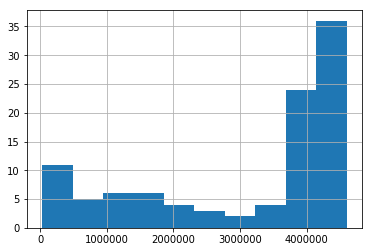

In [58]:
# converting to pure pandas (e.g. for plotting)

pandas_df = df.toPandas()
pandas_df['total'].hist()

------------

## Spark SQL

In [59]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
df = sqlCtx.read.json("census_2010.json")

In [61]:
# registering as a table

df.registerTempTable("census2010")

tables = sqlCtx.tableNames()
print(tables)

['census2010']


In [64]:
# quering

q = "SELECT age FROM census2010"

sqlCtx.sql(q).show(5) # 'show' needed due to Spark's lazy loading 

+---+
|age|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+
only showing top 5 rows



In [67]:
q = '''
SELECT
    males,
    females
FROM
    census2010
WHERE age > 5 AND age < 15
'''

sqlCtx.sql(q).show()

+-------+-------+
|  males|females|
+-------+-------+
|2093905|2007781|
|2097080|2010281|
|2101670|2013771|
|2108014|2018603|
|2114217|2023289|
|2118390|2026352|
|2132030|2037286|
|2159943|2060100|
|2195773|2089651|
+-------+-------+



In [68]:
# SQL query in Spark return a spark dataframe object. So we can combine logic.

q = '''
SELECT
    males,
    females
FROM
    census2010
'''

sqlCtx.sql(q).describe().show()

+-------+------------------+-----------------+
|summary|             males|          females|
+-------+------------------+-----------------+
|  count|               101|              101|
|   mean|1520095.3168316833|1571460.287128713|
| stddev|  818587.208016823|748671.0493484351|
|    min|              4612|            25673|
|    max|           2285990|          2331572|
+-------+------------------+-----------------+



In [70]:
# adding tables

df1980 = sqlCtx.read.json("census_1980.json")
df1980.registerTempTable('census1980')

df1990 = sqlCtx.read.json("census_1990.json")
df1990.registerTempTable('census1990')

df2000 = sqlCtx.read.json("census_2000.json")
df2000.registerTempTable('census2000')


tables = sqlCtx.tableNames()
print(tables)

['census1980', 'census1990', 'census2000', 'census2010']


In [72]:
q = '''
SELECT
    c10.total,
    c00.total
FROM
    census2010 AS c10
INNER JOIN
    census2000 AS c00 ON c10.age = c00.age 
'''

sqlCtx.sql(q).show(5)

+-------+-------+
|  total|  total|
+-------+-------+
|4079669|3733034|
|4085341|3825896|
|4089295|3904845|
|4092221|3970865|
|4094802|4024943|
+-------+-------+
only showing top 5 rows



In [73]:
q = '''
SELECT
    SUM(c10.total),
    SUM(c00.total),
    SUM(c90.total)
FROM
    census2010 AS c10
INNER JOIN
    census2000 AS c00 ON c10.age = c00.age
INNER JOIN
    census1990 AS c90 ON c00.age = c90.age
'''

sqlCtx.sql(q).show(5)

+----------+----------+----------+
|sum(total)|sum(total)|sum(total)|
+----------+----------+----------+
| 312247116| 284594395| 254506647|
+----------+----------+----------+

